## Introduction

In this notebook, the predictions from the various models will be scored. The key metric is Quadratic Weighted Kappa which measures the agreement between two raters. I will also create histograms and confusion matrices for each essay set's predictions--some of these visualizations will be used in the paper. I begin with the predictions of the persuasive essay scores before moving to the source-dependent and then narrative essays.

## Persuasive essays

I first read the CSV files. Then, a small adjustment needs to be made. The range for the persuasive predictions was accidentally 0 to 5 when it should have been 1 to 6. In other words, the range is correct, but all the predictions have to be incremented by 1--easy enough to implement.

In [1]:
# enable AWS functionalities
!pip install boto3
!pip install s3fs

import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 77.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.103
    Uninstalling botocore-1.34.103:
      Successfully uninstalled botocore-1.34.103
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.

In [2]:
test_persuasive_model_input = pd.read_csv('s3://698modeldata/test_persuasive_model_input.csv')
final_persuasive_predictions_df = pd.read_csv('s3://698modelpredictions/final_persuasive_predictions_df.csv')
final_persuasive_predictions_using_narrative_df = pd.read_csv('s3://698modelpredictions/final_persuasive_predictions_using_narrative_df.csv')



In [3]:
final_persuasive_predictions_df['prediction'] += 1


Within the persuasive essay dataset, there are actually two sets of essays. They have different scoring logics, and so it's important that the predictions have, not just the essay ids, but also the essay set numbers.

In [4]:
essay_set_mapping = test_persuasive_model_input[['essay_id', 'essay_set']].drop_duplicates() # create df with essay_id and essay_set

# Merge predictions df with the mapping df
final_persuasive_predictions_df = pd.merge(
    final_persuasive_predictions_df,
    essay_set_mapping,
    on='essay_id',
    how='left'
)
# And the same for the other predictions df
final_persuasive_predictions_using_narrative_df = pd.merge(
    final_persuasive_predictions_using_narrative_df,
    essay_set_mapping,
    on='essay_id',
    how='left'
)

final_persuasive_predictions_df.head()

,essay_id,active_feature,prediction,target_score,essay_set
0,3587,score_type_domain1_score,3,3.0,2
1,3587,score_type_domain2_score,3,2.0,2
2,926,score_type_rater1_domain1,3,4.0,1
3,926,score_type_rater2_domain1,3,3.0,1
4,648,score_type_rater1_domain1,4,3.0,1


And now we can work on Essay 1. It's critical to note, and this goes for the entire notebook, that the resolved score is a function of the different subscores that the model directly predicted. In this case, the model made predictions for score_type_rater1_domain1 and score_type_rater2_domain1. We'd like a pivoted table, then, with one essay per row (essentially transforming the data from long to wide). We then calculate the resolved score (in this case called domain_1_score) by adding the two raters' scores.

Note: for details about each essay's scoring logic, please consult the data preparation notebook.

In [5]:
# Filtering for essay 1 scores
filtered_df = final_persuasive_predictions_df[
    final_persuasive_predictions_df['essay_set'] == 1
]


pivot_df = filtered_df.pivot_table(
    index='essay_id', # unique identifier
    columns='active_feature', # each unique value in active_feature becomes a column with the value prediction
    values='prediction',
    aggfunc='first' # in case there are multiple entries for each essay_id and active_feature, we just want the first one
).reset_index()

pivot_df.columns = ['essay_id', 'predicted_rater1_domain1', 'predicted_rater2_domain1']

pivot_df['predicted_domain1_score'] = pivot_df['predicted_rater1_domain1'] + pivot_df['predicted_rater2_domain1']


In [6]:
filtered_df.head()

,essay_id,active_feature,prediction,target_score,essay_set
2,926,score_type_rater1_domain1,3,4.0,1
3,926,score_type_rater2_domain1,3,3.0,1
4,648,score_type_rater1_domain1,4,3.0,1
5,648,score_type_rater2_domain1,4,3.0,1
6,698,score_type_rater1_domain1,3,3.0,1


In [7]:
# The process is repeated for the predictions on persuasive essays made using the model trained on the narrative essays.

filtered_narrative_df = final_persuasive_predictions_using_narrative_df[
    final_persuasive_predictions_using_narrative_df['essay_set'] == 1
]

narrative_pivot_df = filtered_narrative_df.pivot_table(
    index='essay_id',
    columns='feature',
    values='prediction',
    aggfunc='first'
).reset_index()

narrative_pivot_df.columns = ['essay_id', 'narrative_predicted_rater1_domain1', 'narrative_predicted_rater2_domain1']

narrative_pivot_df['narrative_predicted_domain1_score'] = narrative_pivot_df['narrative_predicted_rater1_domain1'] + narrative_pivot_df['narrative_predicted_rater2_domain1']


Now for the input data (that is, with the actual scores including the actual resolved scores), we filter for only essay 1 and then aggregate data by essay_id. Because rater1_domain 1 might be NaN in one of the rows, we select the max--this is to say, the actual value.

In [8]:
set1_data = test_persuasive_model_input[test_persuasive_model_input['essay_set'] == 1]

# We only want one row per essay_id for set 1
aggregated_scores_set1 = set1_data.groupby('essay_id').agg({
    'essay_set': 'first',
    'rater1_domain1': 'max',  # to ignore the NaN row
    'rater2_domain1': 'max',  # to ignore the NaN row
    'domain1_score': 'first'
}).reset_index()

print(aggregated_scores_set1.head(20))


    essay_id  essay_set  rater1_domain1  rater2_domain1  domain1_score
0          6          1             4.0             4.0            8.0
1         11          1             4.0             4.0            8.0
2         12          1             4.0             4.0            8.0
3         15          1             3.0             3.0            6.0
4         19          1             2.0             2.0            4.0
5         22          1             2.0             1.0            3.0
6         33          1             3.0             3.0            6.0
7         36          1             5.0             5.0           10.0
8         46          1             4.0             4.0            8.0
9         48          1             6.0             5.0           11.0
10        50          1             2.0             3.0            5.0
11        74          1             4.0             3.0            7.0
12        83          1             3.0             4.0            7.0
13    

We keep the essential columns from the actual scored data and merge them with the predictions data using the column essay_id.

In [9]:
actual_scores_df = aggregated_scores_set1[['essay_id', 'essay_set', 'rater1_domain1', 'rater2_domain1', 'domain1_score']]

# Merge actual scores with both predicted
persuasive_all_scores = pd.merge(actual_scores_df, pivot_df, on='essay_id', how='left') # first merging the predictions using the persuasive model
persuasive_all_scores = pd.merge(persuasive_all_scores, narrative_pivot_df, on='essay_id', how='left') # next merging the predictions using the narrative model


The QWK can now be calculated. For sake of completeness, the following will be calculated:

1. The QWK for rater 1 using the persuasive  model
2. The QWK for rater 1 using the narrative model
3. The QWK for rater 2 using the persuasive  model
4. The QWK for rater 2 using the narrative model
5. The QWK for the resolved score (called domain1_score) using the persuasive model
6. The QWK for the resolved score (called domain1_score) using the narrative model
7. The QWK for the two human raters

In [10]:
from sklearn.metrics import cohen_kappa_score

def calculate_qwk_scores(df, description):
    qwk_rater1 = cohen_kappa_score(
        df['predicted_rater1_domain1'],
        df['rater1_domain1'],
        weights='quadratic'
    )
    qwk_narrative_rater1 = cohen_kappa_score(
        df['narrative_predicted_rater1_domain1'],
        df['rater1_domain1'],
        weights='quadratic'
    )
    qwk_rater2 = cohen_kappa_score(
        df['predicted_rater2_domain1'],
        df['rater2_domain1'],
        weights='quadratic'
    )
    qwk_narrative_rater2 = cohen_kappa_score(
        df['narrative_predicted_rater2_domain1'],
        df['rater2_domain1'],
        weights='quadratic'
    )
    qwk_domain1 = cohen_kappa_score(
        df['predicted_domain1_score'],
        df['domain1_score'],
        weights='quadratic'
    )
    qwk_narrative_domain1 = cohen_kappa_score(
        df['narrative_predicted_domain1_score'],
        df['domain1_score'],
        weights='quadratic'
    )
    qwk_raters = cohen_kappa_score(
    df['rater1_domain1'],
    df['rater2_domain1'],
    weights='quadratic'
    )

    print(f"Results for {description}:")
    print("QWK for Rater1:", qwk_rater1)
    print("Narrative QWK for Rater1:", qwk_narrative_rater1)
    print("QWK for Rater2:", qwk_rater2)
    print("Narrative QWK for Rater2:", qwk_narrative_rater2)
    print("QWK for Domain1 Score:", qwk_domain1)
    print("Narrative QWK for Domain1 Score:", qwk_narrative_domain1)
    print("Human Raters QWK for Domain1 Score:", qwk_raters)
    print("\n")

calculate_qwk_scores(persuasive_all_scores, "Essay 1")

Results for Essay 1:
QWK for Rater1: 0.6721144967682364
Narrative QWK for Rater1: 0.11616290983606559
QWK for Rater2: 0.7040528233151184
Narrative QWK for Rater2: 0.09347803107712904
QWK for Domain1 Score: 0.7485568231407019
Narrative QWK for Domain1 Score: 0.10902886265270062
Human Raters QWK for Domain1 Score: 0.7315705128205128




We can also create histograms on the same plot so see differences in the distrubutions for actual and predicted resolved scores.

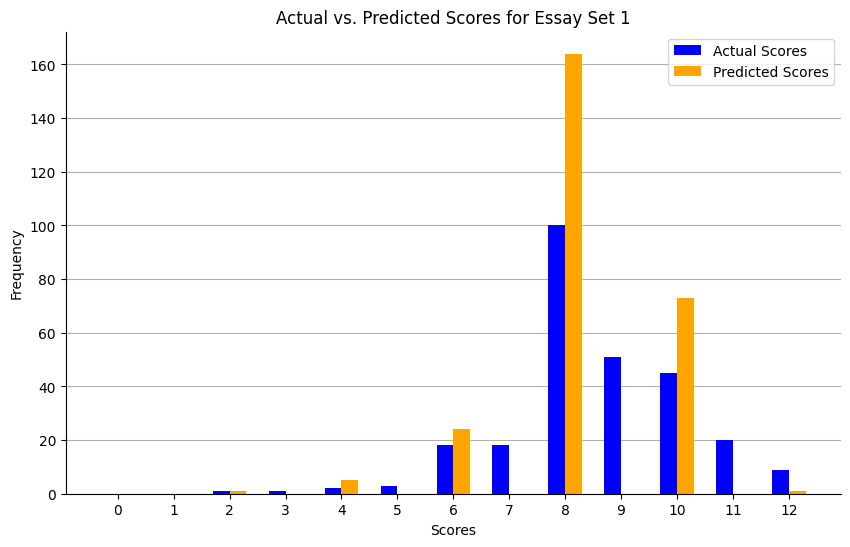

In [11]:
import matplotlib.pyplot as plt
import numpy as np

actual_scores = persuasive_all_scores['domain1_score'].astype(int)
predicted_scores = persuasive_all_scores['predicted_domain1_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Ensure the length of both counts arrays are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Predicted Scores for Essay Set 1')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()




It looks like almost all predicted resolved scores are even, suggesting perhaps that the predicted scores for each rater are the same.

In [78]:
filtered_df1 = persuasive_all_scores[persuasive_all_scores['essay_set'] == 1]

percent_same_predicted = (filtered_df1['predicted_rater1_domain1'] == filtered_df1['predicted_rater2_domain1']).mean() * 100
percent_same_actual = (filtered_df1['rater1_domain1'] == filtered_df1['rater2_domain1']).mean() * 100

print(f"Percentage of rows where predicted ratings are the same: {percent_same_predicted:.2f}%")
print(f"Percentage of rows where actual ratings are the same: {percent_same_actual:.2f}%")

Percentage of rows where predicted ratings are the same: 100.00%
Percentage of rows where actual ratings are the same: 64.18%


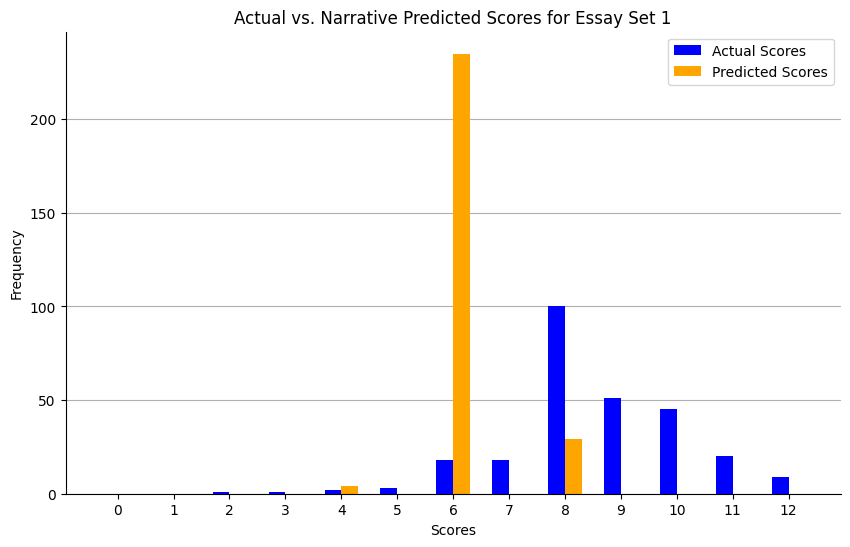

In [12]:
# narrative predicted

actual_scores = persuasive_all_scores['domain1_score'].astype(int)
predicted_scores = persuasive_all_scores['narrative_predicted_domain1_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Ensure the length of both counts arrays are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Narrative Predicted Scores for Essay Set 1')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()




In [13]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix for the standard model predictions
cm_standard = confusion_matrix(
    persuasive_all_scores['domain1_score'],
    persuasive_all_scores['predicted_domain1_score']
)
print("Confusion Matrix for Domain1 Score vs. Predicted Domain1 Score:")
print(cm_standard)

# Calculate confusion matrix for the narrative model predictions
cm_narrative = confusion_matrix(
    persuasive_all_scores['domain1_score'],
    persuasive_all_scores['narrative_predicted_domain1_score']
)
print("\nConfusion Matrix for Domain1 Score vs. Narrative Predicted Domain1 Score:")
print(cm_narrative)


Confusion Matrix for Domain1 Score vs. Predicted Domain1 Score:
[[ 1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  1  0  0  0  0]
 [ 0  0  0  0 13  0  5  0  0  0  0]
 [ 0  0  0  0  9  0  9  0  0  0  0]
 [ 0  0  0  0  2  0 91  0  7  0  0]
 [ 0  0  0  0  0  0 35  0 15  0  1]
 [ 0  0  0  0  0  0 21  0 24  0  0]
 [ 0  0  0  0  0  0  2  0 18  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0]]

Confusion Matrix for Domain1 Score vs. Narrative Predicted Domain1 Score:
[[ 0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  1  0  2  0  0  0  0  0  0]
 [ 0  0  2  0 16  0  0  0  0  0  0]
 [ 0  0  1  0 17  0  0  0  0  0  0]
 [ 0  0  0  0 99  0  1  0  0  0  0]
 [ 0  0  0  0 47  0  4  0  0  0  0]
 [ 0  0  0  0 34  0 11  0  0  0  0]
 [ 0  0  0  0 12  0  8  0  0  0  0]
 [ 0  0  0  0  4  0  5  0  0  0  0]]


Performance for set 2 is now evaluated. Note, the structure of the process is nearly identical for this essay set and beyond (with the main adjustments being to the scoring logic). Significant commentary will only be added when the there is an adjustment to the process, otherwise it is repititious; the commentary for set 1 can be consulted to clarify any questions about the process.

In [14]:
# filtering for set 2 for both predictions dataframes

filtered_df_set2 = final_persuasive_predictions_df[
    final_persuasive_predictions_df['essay_set'] == 2
]

filtered_narrative_df_set2 = final_persuasive_predictions_using_narrative_df[
    final_persuasive_predictions_using_narrative_df['essay_set'] == 2
]


In [15]:
# Pivoting from long to wide
pivot_df_set2 = filtered_df_set2.pivot_table(
    index='essay_id',
    columns='active_feature',
    values='prediction',
    aggfunc='first'
).reset_index()

narrative_pivot_df_set2 = filtered_narrative_df_set2.pivot_table(
    index='essay_id',
    columns='feature',
    values='prediction',
    aggfunc='first'
).reset_index()

pivot_df_set2.columns = ['essay_id', 'predicted_domain1_score', 'predicted_domain2_score'] # renaming
narrative_pivot_df_set2.columns = ['essay_id', 'narrative_predicted_domain1_score', 'narrative_predicted_domain2_score'] # renaming


In [16]:
aggregated_scores_set2 = test_persuasive_model_input[
    test_persuasive_model_input['essay_set'] == 2 # Filtering for only set 2
# Aggregating so that there is one row per essay_id
].groupby('essay_id').agg({
    'essay_set': 'first',
    'domain1_score': 'first',
    'domain2_score': 'first'
}).reset_index()

# Merging actual scored and predictions
final_scores_set2 = pd.merge(aggregated_scores_set2, pivot_df_set2, on='essay_id', how='left')
final_scores_set2 = pd.merge(final_scores_set2, narrative_pivot_df_set2, on='essay_id', how='left')


Now I again calculate key metrics. For this essay set (unlike all the other ones), there are two resolved scores: one for domain1 and the other for domain2. These are simply the rater1's scores for both domains.

In [17]:
qwk_predicted_domain1 = cohen_kappa_score(
    final_scores_set2['predicted_domain1_score'],
    final_scores_set2['domain1_score'],
    weights='quadratic'
)

qwk_narrative_predicted_domain1 = cohen_kappa_score(
    final_scores_set2['narrative_predicted_domain1_score'],
    final_scores_set2['domain1_score'],
    weights='quadratic'
)

print("QWK for predicted domain 1 score:", qwk_predicted_domain1)
print("QWK for narrative predicted domain 1 score:", qwk_narrative_predicted_domain1)

qwk_predicted_domain2 = cohen_kappa_score(
    final_scores_set2['predicted_domain2_score'],
    final_scores_set2['domain2_score'],
    weights='quadratic'
)

qwk_narrative_predicted_domain2 = cohen_kappa_score(
    final_scores_set2['narrative_predicted_domain2_score'],
    final_scores_set2['domain2_score'],
    weights='quadratic'
)

print("QWK for predicted domain 2 score:", qwk_predicted_domain2)
print("QWK for narrative predicted domain 2 score:", qwk_narrative_predicted_domain2)


QWK for predicted domain 1 score: 0.6437994722955146
QWK for narrative predicted domain 1 score: 0.5696235851539879
QWK for predicted domain 2 score: 0.6289862587503241
QWK for narrative predicted domain 2 score: 0.52226481863757


Now let's see to what extent the raters agreed with each other. The data will be aggregated to dismiss NaN values, and then the agreement for each domain will be calculated.

In [18]:
aggregated_set2_for_raters = test_persuasive_model_input[test_persuasive_model_input['essay_set'] == 2].groupby('essay_id').agg({
    'essay_set': 'first',
    'rater1_domain1': 'max',  # non-NaN entries are consistent
    'rater2_domain1': 'max',
    'rater1_domain2': 'max',
    'rater2_domain2': 'max',
}).reset_index()

print(aggregated_set2_for_raters.head())


   essay_id  essay_set  rater1_domain1  rater2_domain1  rater1_domain2  \
0      2985          2             2.0             3.0             2.0   
1      3000          2             3.0             3.0             3.0   
2      3006          2             3.0             3.0             3.0   
3      3007          2             3.0             3.0             3.0   
4      3017          2             4.0             4.0             4.0   

   rater2_domain2  
0             3.0  
1             3.0  
2             3.0  
3             3.0  
4             4.0  


In [19]:
qwk_raters_domain1 = cohen_kappa_score(
    aggregated_set2_for_raters['rater1_domain1'],
    aggregated_set2_for_raters['rater2_domain1'],
    weights='quadratic'
)

qwk_raters_domain2 = cohen_kappa_score(
    aggregated_set2_for_raters['rater1_domain2'],
    aggregated_set2_for_raters['rater2_domain2'],
    weights='quadratic'
)

print("QWK between raters for domain 1:", qwk_raters_domain1)
print("QWK between raters for domain 2:", qwk_raters_domain2)


QWK between raters for domain 1: 0.8116379606120909
QWK between raters for domain 2: 0.8090614886731391


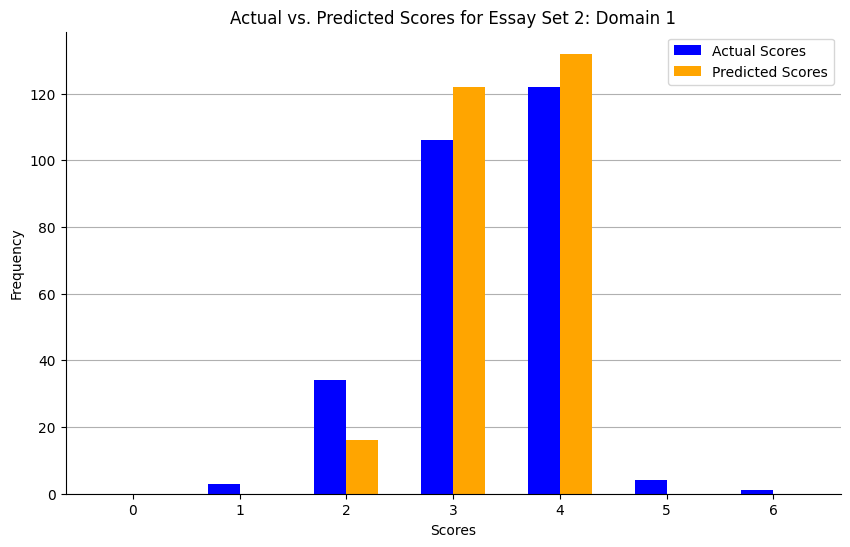

In [20]:
# Histogram for set 2: domain 1
actual_scores = final_scores_set2['domain1_score'].astype(int)
predicted_scores = final_scores_set2['predicted_domain1_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Making sure counts array lengths are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Predicted Scores for Essay Set 2: Domain 1')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()





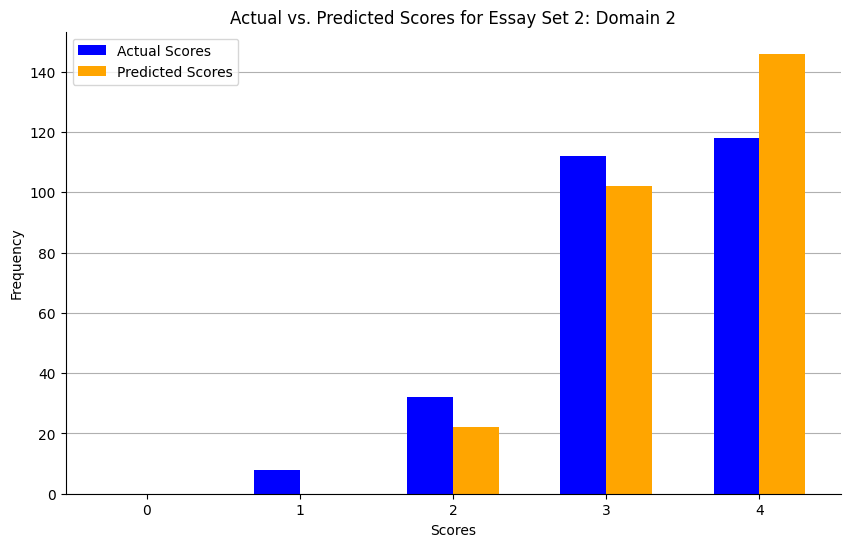

In [21]:
# Histogram for set 2: domain 2
actual_scores = final_scores_set2['domain2_score'].astype(int)
predicted_scores = final_scores_set2['predicted_domain2_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Making sure counts array lengths are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Predicted Scores for Essay Set 2: Domain 2')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()





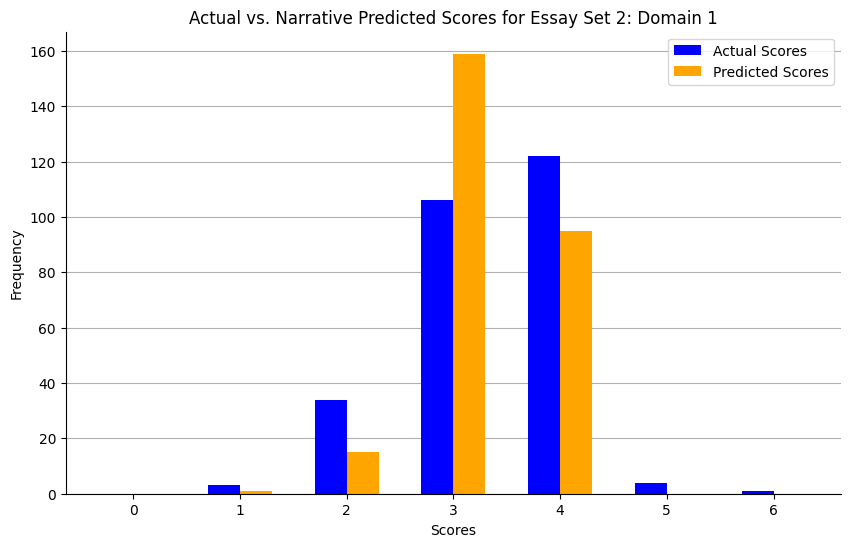

In [22]:
# narrative predicted

actual_scores = final_scores_set2['domain1_score'].astype(int)
predicted_scores = final_scores_set2['narrative_predicted_domain1_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Ensure the length of both counts arrays are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Narrative Predicted Scores for Essay Set 2: Domain 1')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()




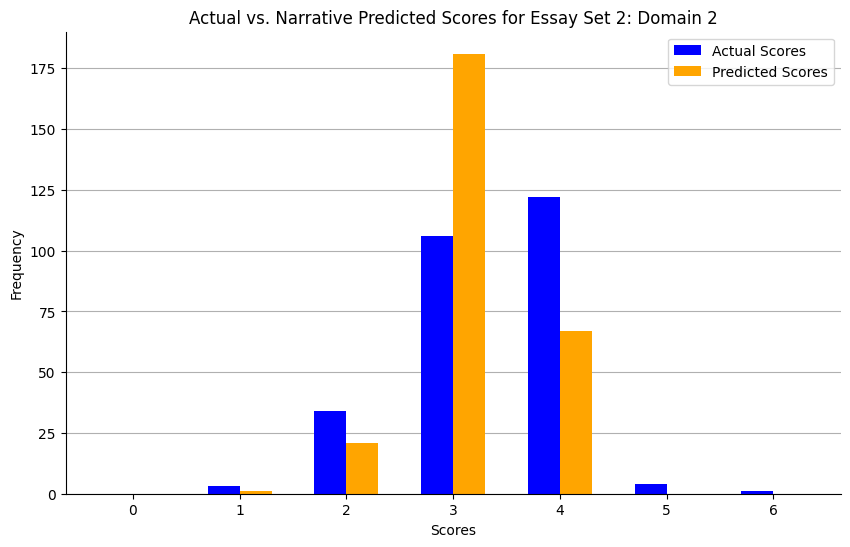

In [23]:
# narrative predicted

actual_scores = final_scores_set2['domain1_score'].astype(int)
predicted_scores = final_scores_set2['narrative_predicted_domain2_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Ensure the length of both counts arrays are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Narrative Predicted Scores for Essay Set 2: Domain 2')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()




So clearly the model performs much worse than it did for the first set. 4 confusion matrices will be built (one for each model for each domain).

In [24]:
# Persuasive model domain 1
cm_standard_domain1 = confusion_matrix(
    final_scores_set2['domain1_score'],
    final_scores_set2['predicted_domain1_score']
)

# Narrative model domain 1
cm_narrative_domain1 = confusion_matrix(
    final_scores_set2['domain1_score'],
    final_scores_set2['narrative_predicted_domain1_score']
)

# Persuasive model domain 2
cm_standard_domain2 = confusion_matrix(
    final_scores_set2['domain2_score'],
    final_scores_set2['predicted_domain2_score']
)

# Narrative model domain 2
cm_narrative_domain2 = confusion_matrix(
    final_scores_set2['domain2_score'],
    final_scores_set2['narrative_predicted_domain2_score']
)

print("Confusion Matrix for persuasive model domain 1:")
print(cm_standard_domain1)

print("Confusion Matrix for narrative model domain 1:")
print(cm_narrative_domain1)

print("Confusion Matrix for persuasive model domain 2:")
print(cm_standard_domain2)

print("Confusion Matrix for narrative model domain 2:")
print(cm_narrative_domain2)


Confusion Matrix for persuasive model domain 1:
[[ 0  3  0  0  0  0]
 [ 0 12 19  3  0  0]
 [ 0  1 79 26  0  0]
 [ 0  0 24 98  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  1  0  0]]
Confusion Matrix for narrative model domain 1:
[[ 1  1  1  0  0  0]
 [ 0 11 21  2  0  0]
 [ 0  3 88 15  0  0]
 [ 0  0 49 73  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  1  0  0]]
Confusion Matrix for persuasive model domain 2:
[[ 0  6  2  0]
 [ 0 14 16  2]
 [ 0  1 66 45]
 [ 0  1 18 99]]
Confusion Matrix for narrative model domain 2:
[[ 1  4  3  0]
 [ 0 13 18  1]
 [ 0  3 97 12]
 [ 0  1 63 54]]


In [104]:
print(final_scores_set2["domain1_score"].value_counts())
print(final_scores_set2["domain2_score"].value_counts())
print(final_scores_set2["predicted_domain1_score"].value_counts())
print(final_scores_set2["predicted_domain2_score"].value_counts())

domain1_score
4.0    122
3.0    106
2.0     34
5.0      4
1.0      3
6.0      1
Name: count, dtype: int64
domain2_score
4.0    118
3.0    112
2.0     32
1.0      8
Name: count, dtype: int64
predicted_domain1_score
4    132
3    122
2     16
Name: count, dtype: int64
predicted_domain2_score
4    146
3    102
2     22
Name: count, dtype: int64


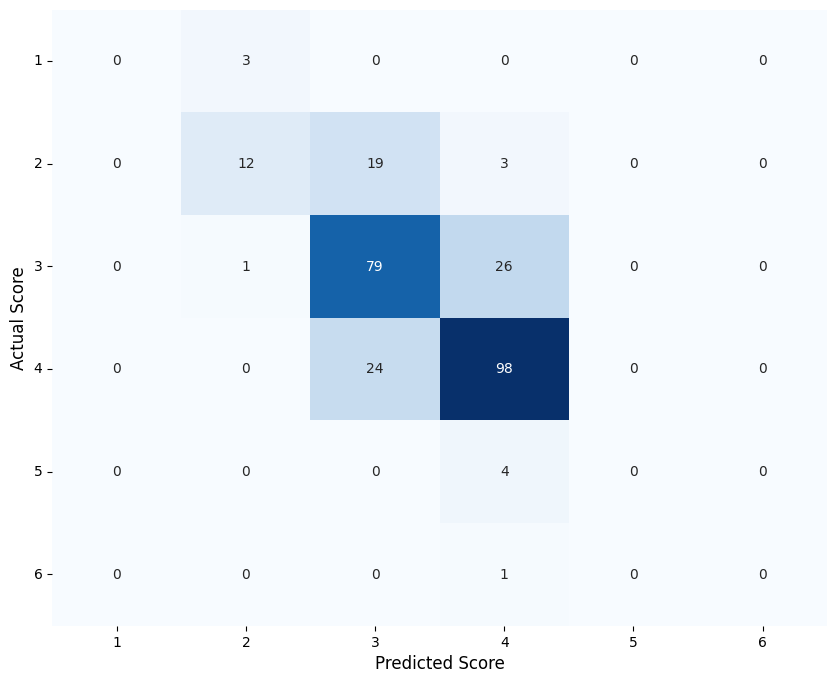

In [114]:
# nicer heatmaps for the paper

import seaborn as sns

plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm_standard_domain1, annot=True, cmap="Blues", fmt="d", cbar=False) # other plot will have bar
min = 0
vmax = 99 # the highest value in the next heatmap
score_range = range(1, 7)
# Correct tick labels (start at 1 instead of 0)
ax.set_xticklabels(score_range, rotation=0)
ax.set_yticklabels(score_range, rotation=0)

plt.xlabel("Predicted Score", fontsize=12)
plt.ylabel("Actual Score", fontsize=12)
#plt.title(f"Confusion Matrix for Essay 2: Domain 1")

plt.show()

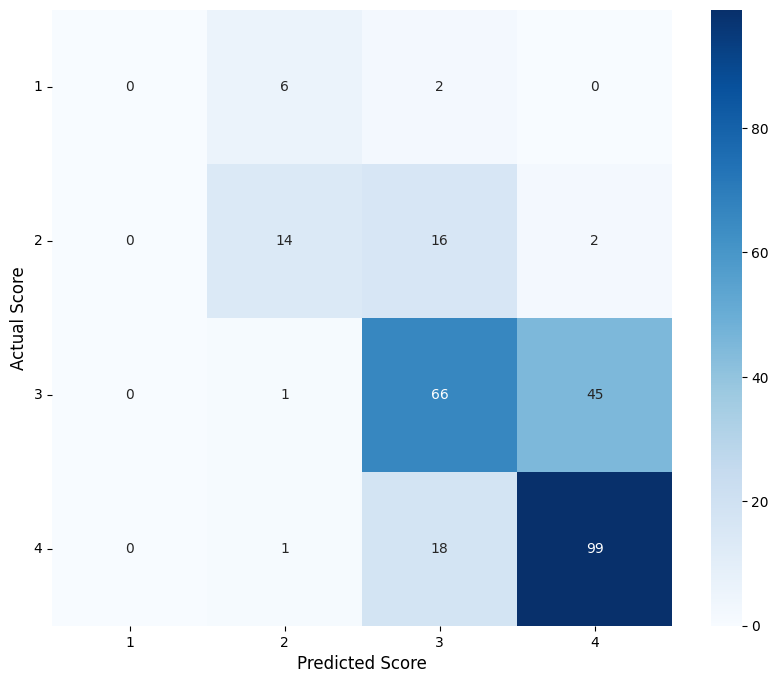

In [116]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm_standard_domain2, annot=True, cmap="Blues", fmt="d")
min = 0
vmax = 99 # the highest value in the next heatmap
score_range = range(1, 5)
# Correct tick labels (start at 1 instead of 0)
ax.set_xticklabels(score_range, rotation=0)
ax.set_yticklabels(score_range, rotation=0)

plt.xlabel("Predicted Score", fontsize=12)
plt.ylabel("Actual Score", fontsize=12)
#plt.title(f"Confusion Matrix for Essay 2: Domain 2")

plt.show()

## Source-dependent essays

We move now to the second model (source-dependent). Again, we used the narrative model to make predictions on this test set as well. As earlier, commentary will be limited, since the structure is the same as the earlier sets.

In [25]:
test_sd_model_input = pd.read_csv('s3://698modeldata/test_source_dependent_model_input.csv')
final_sd_predictions_df = pd.read_csv('s3://698modelpredictions/final_sd_predictions_df.csv')
final_sd_predictions_using_narrative_df = pd.read_csv('s3://698modelpredictions/final_sd_predictions_using_narrative_df.csv')

In [26]:
essay_set_mapping = test_sd_model_input[['essay_id', 'essay_set']].drop_duplicates() # create df with essay_id and essay_set

# Merging the prediction dfs so that they have the essay_id
final_sd_predictions_df = pd.merge(
    final_sd_predictions_df,
    essay_set_mapping,
    on='essay_id',
    how='left'
)

final_sd_predictions_using_narrative_df = pd.merge(
    final_sd_predictions_using_narrative_df,
    essay_set_mapping,
    on='essay_id',
    how='left'
)

The scoring logic for essays 3 and 4 is identical, so the scoring process will be done for both simultaneously.

In [27]:
filtered_df = final_sd_predictions_df[
    final_sd_predictions_df['essay_set'].isin([3, 4]) # Filtering the df to only include sets 3 and 4
]

# Pivoting the df from long to wide
pivot_df = filtered_df.pivot_table(
    index='essay_id',
    columns='feature',
    values='prediction',
    aggfunc='first'
).reset_index()


In [28]:
# Repeating the process for the df that makes predictions using the narrative model
filtered_narrative_df = final_sd_predictions_using_narrative_df[
    final_sd_predictions_using_narrative_df['essay_set'].isin([3, 4])
]

narrative_pivot_df = filtered_narrative_df.pivot_table(
    index='essay_id',
    columns='feature',
    values='prediction',
    aggfunc='first'
).reset_index()




The scoring logic is: if the two raters' scores are adjacent or equal, the higher of the two scores is the resolved score. Otherwise, the resolved score is the average of the two scores rounded to the nearest integer. Again, details about the scoring logic can be found in the data preparation notebook.

In [29]:
def calculate_score(row):
    if abs(row['score_type_rater1_domain1'] - row['score_type_rater2_domain1']) <= 1:
        return max(row['score_type_rater1_domain1'], row['score_type_rater2_domain1'])
    else:
        return round(np.mean([row['score_type_rater1_domain1'], row['score_type_rater2_domain1']]))

pivot_df['predicted_domain1_score'] = pivot_df.apply(calculate_score, axis=1)
narrative_pivot_df['narrative_predicted_domain1_score'] = narrative_pivot_df.apply(calculate_score, axis=1)





In [30]:
# Renaming for clarity
pivot_df.rename(columns={
    'score_type_rater1_domain1': 'predicted_rater1_domain1',
    'score_type_rater2_domain1': 'predicted_rater2_domain1'
}, inplace=True)

narrative_pivot_df.rename(columns={
    'score_type_rater1_domain1': 'narrative_predicted_rater1_domain1',
    'score_type_rater2_domain1': 'narrative_predicted_rater2_domain1'
}, inplace=True)

In [31]:
# Filtering the actual scores df to only include sets 3 and 4
set_data = test_sd_model_input[test_sd_model_input['essay_set'].isin([3, 4])]

# Aggregating so that there is one row per essay_id
aggregated_scores_set34 = set_data.groupby('essay_id').agg({
    'essay_set': 'first',
    'rater1_domain1': 'max',  # to ignore NaN
    'rater2_domain1': 'max',  # to ignore NaN
    'domain1_score': 'first'
}).reset_index()


In [32]:
# merging all the dataframes
final_scores_set34 = pd.merge(aggregated_scores_set34, pivot_df, on='essay_id', how='left')
final_scores_set34 = pd.merge(final_scores_set34, narrative_pivot_df, on='essay_id', how='left')

In [33]:
# splitting the merged dataframe based on essay set (this will simplify calculations)
final_scores_set3 = final_scores_set34[final_scores_set34['essay_set'] == 3]
final_scores_set4 = final_scores_set34[final_scores_set34['essay_set'] == 4]

In [34]:
print(final_scores_set4[final_scores_set4.isna().any(axis=1)])



     essay_id  essay_set  rater1_domain1  rater2_domain1  domain1_score  \
509     10534          4             NaN             NaN            NaN   

     predicted_rater1_domain1  predicted_rater2_domain1  \
509                       NaN                       NaN   

     predicted_domain1_score  narrative_predicted_rater1_domain1  \
509                      NaN                                   3   

     narrative_predicted_rater2_domain1  narrative_predicted_domain1_score  
509                                   3                                  3  


It turns out there is one row with missing data; this row can just be dropped.

In [35]:
final_scores_set4_copy = final_scores_set4.copy()
final_scores_set4_copy.dropna(inplace=True)
final_scores_set4 = final_scores_set4_copy

In [36]:
# Because there is only one domain score, we can use the function from earlier (see set 1)
calculate_qwk_scores(final_scores_set3, "Essay Set 3")
calculate_qwk_scores(final_scores_set4, "Essay Set 4")

Results for Essay Set 3:
QWK for Rater1: 0.7515281089822657
Narrative QWK for Rater1: 0.032715057689499116
QWK for Rater2: 0.6899844115354637
Narrative QWK for Rater2: 0.027677322918173597
QWK for Domain1 Score: 0.7234053245888458
Narrative QWK for Domain1 Score: 0.0421111111111111
Human Raters QWK for Domain1 Score: 0.72551003203507


Results for Essay Set 4:
QWK for Rater1: 0.7606185976766454
Narrative QWK for Rater1: 0.003408156070043411
QWK for Rater2: 0.7731264507815465
Narrative QWK for Rater2: 0.005372915096345188
QWK for Domain1 Score: 0.7747770048931026
Narrative QWK for Domain1 Score: 0.0048030143055296515
Human Raters QWK for Domain1 Score: 0.8767062794237093




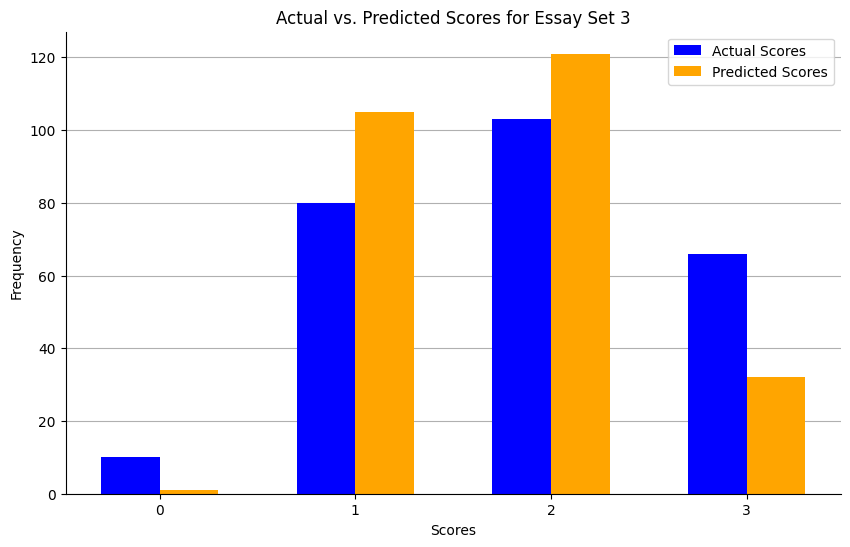

In [37]:
# Histogram for set 3
actual_scores = final_scores_set3['domain1_score'].astype(int)
predicted_scores = final_scores_set3['predicted_domain1_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Making sure counts array lengths are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Predicted Scores for Essay Set 3')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()



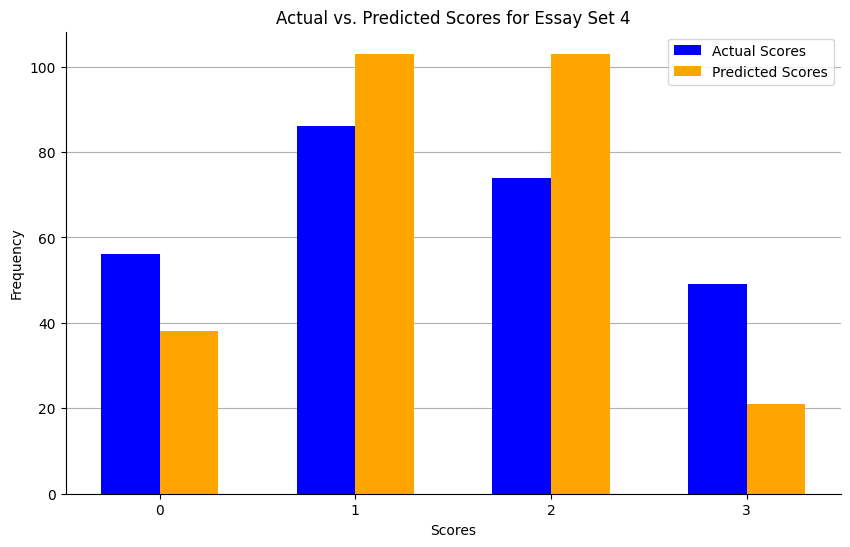

In [38]:
# Histogram for set 4
actual_scores = final_scores_set4['domain1_score'].astype(int)
predicted_scores = final_scores_set4['predicted_domain1_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Making sure counts array lengths are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Predicted Scores for Essay Set 4')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()





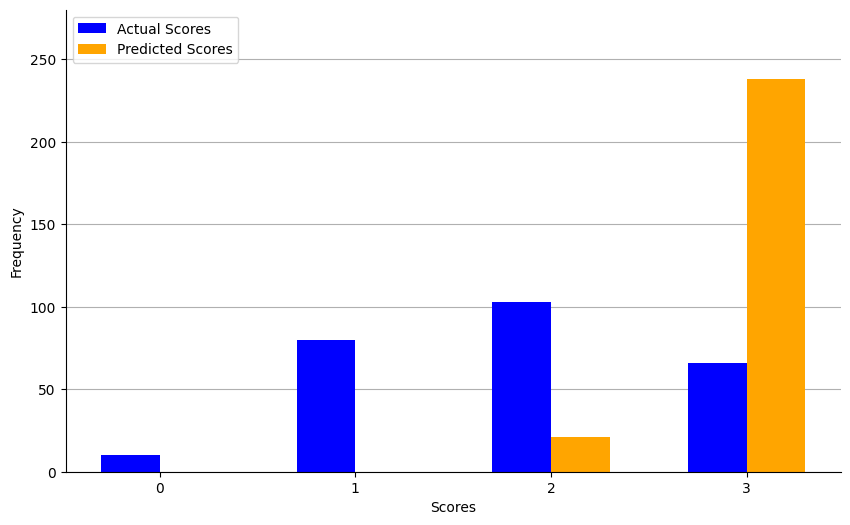

In [88]:
# narrative predicted histogram for set 3
actual_scores = final_scores_set3['domain1_score'].astype(int)
predicted_scores = final_scores_set3['narrative_predicted_domain1_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Making sure counts array lengths are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
#plt.title('Actual vs. Narrative Predicted Scores for Essay Set 3')
plt.xticks(score_labels)
plt.legend(loc='upper left')
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.ylim(0, 280) # so it will line up with the next plot
plt.show()



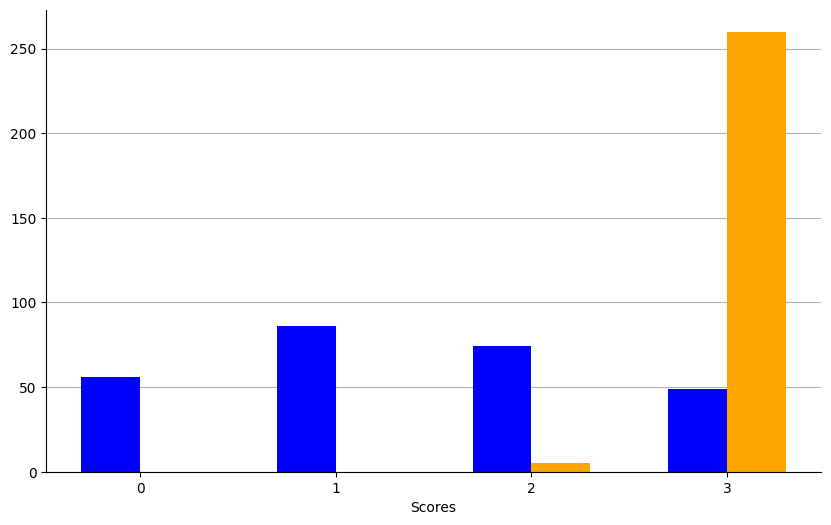

In [79]:
# narrative predicted histogram for set 4
actual_scores = final_scores_set4['domain1_score'].astype(int)
predicted_scores = final_scores_set4['narrative_predicted_domain1_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Making sure counts array lengths are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
#plt.ylabel('Frequency')
#plt.title('Actual vs. Narrative Predicted Scores for Essay Set 4')
plt.xticks(score_labels)
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()



In [89]:
# Writing a function to streamline the confusion matrices
def print_confusion_matrix(actual, predicted, set_name, model_type):
    cm = confusion_matrix(actual, predicted)
    print(f"Confusion Matrix for {model_type} in {set_name}:")
    print(cm)
    print("\n")

# Essay Set 3
print_confusion_matrix(
    final_scores_set3['domain1_score'],
    final_scores_set3['predicted_domain1_score'],
    "Essay Set 3", "Source-Dependent Model"
)

print_confusion_matrix(
    final_scores_set3['domain1_score'],
    final_scores_set3['narrative_predicted_domain1_score'],
    "Essay Set 3", "Narrative Model"
)

# Essay Set 4
print_confusion_matrix(
    final_scores_set4['domain1_score'],
    final_scores_set4['predicted_domain1_score'],
    "Essay Set 4", "Source-Dependent Model"
)

print_confusion_matrix(
    final_scores_set4['domain1_score'],
    final_scores_set4['narrative_predicted_domain1_score'],
    "Essay Set 4", "Narrative Model"
)


Confusion Matrix for Source-Dependent Model in Essay Set 3:
[[ 1  9  0  0]
 [ 0 71  9  0]
 [ 0 25 74  4]
 [ 0  0 38 28]]


Confusion Matrix for Narrative Model in Essay Set 3:
[[ 0  0  2  8]
 [ 0  0 10 70]
 [ 0  0  8 95]
 [ 0  0  1 65]]


Confusion Matrix for Source-Dependent Model in Essay Set 4:
[[29 26  1  0]
 [ 9 65 12  0]
 [ 0 10 60  4]
 [ 0  2 30 17]]


Confusion Matrix for Narrative Model in Essay Set 4:
[[ 0  0  2 54]
 [ 0  0  2 84]
 [ 0  0  0 74]
 [ 0  0  1 48]]




I now move on to essays 5 and 6--they have an identical scoring logic.

In [42]:
# Filtering for the relevant essays only
filtered_df = final_sd_predictions_df[
    final_sd_predictions_df['essay_set'].isin([5, 6])
]

# Pivoting from wide to long
pivot_df = filtered_df.pivot_table(
    index='essay_id',
    columns='feature',
    values='prediction',
    aggfunc='first'
).reset_index()

# Repeating for the other predictions df (the one using the narrative model)
filtered_narrative_df = final_sd_predictions_using_narrative_df[
    final_sd_predictions_using_narrative_df['essay_set'].isin([5, 6])
]

narrative_pivot_df = filtered_narrative_df.pivot_table(
    index='essay_id',
    columns='feature',
    values='prediction',
    aggfunc='first'
).reset_index()

# Renaming columns for clarity
pivot_df.rename(columns={
    'score_type_rater1_domain1': 'predicted_rater1_domain1',
    'score_type_rater2_domain1': 'predicted_rater2_domain1'
}, inplace=True)

narrative_pivot_df.rename(columns={
    'score_type_rater1_domain1': 'narrative_predicted_rater1_domain1',
    'score_type_rater2_domain1': 'narrative_predicted_rater2_domain1'
}, inplace=True)




The scoring logic for these essays is that the resolved score is simply the maximum of the two raters. There is no special non-adjacency case.

In [43]:
# Calculating resolved scores
pivot_df['predicted_domain1_score'] = pivot_df[['predicted_rater1_domain1', 'predicted_rater2_domain1']].max(axis=1)
narrative_pivot_df['narrative_predicted_domain1_score'] = narrative_pivot_df[['narrative_predicted_rater1_domain1', 'narrative_predicted_rater2_domain1']].max(axis=1)


In [44]:
# We only want actual scores for essays 5 and 6
set_data = test_sd_model_input[test_sd_model_input['essay_set'].isin([5, 6])]

# Aggregating so that there's one row per essay id
aggregated_scores_set56 = set_data.groupby('essay_id').agg({
    'essay_set': 'first',
    'rater1_domain1': 'max',
    'rater2_domain1': 'max',
    'domain1_score': 'first'
}).reset_index()

# Merging all the dfs
final_scores_set56 = pd.merge(aggregated_scores_set56, pivot_df, on='essay_id', how='left')
final_scores_set56 = pd.merge(final_scores_set56, narrative_pivot_df, on='essay_id', how='left')

# Splitting the merged df into 2 based on the essay set number
final_scores_set5 = final_scores_set56[final_scores_set56['essay_set'] == 5]
final_scores_set6 = final_scores_set56[final_scores_set56['essay_set'] == 6]


In [45]:
calculate_qwk_scores(final_scores_set5, "Essay Set 5")
calculate_qwk_scores(final_scores_set6, "Essay Set 6")

Results for Essay Set 5:
QWK for Rater1: 0.782486555903363
Narrative QWK for Rater1: 0.12928194726166342
QWK for Rater2: 0.8247117608059378
Narrative QWK for Rater2: 0.13107390139252473
QWK for Domain1 Score: 0.8110750217856294
Narrative QWK for Domain1 Score: 0.1550850213270596
Human Raters QWK for Domain1 Score: 0.746338959509647


Results for Essay Set 6:
QWK for Rater1: 0.7265948632974317
Narrative QWK for Rater1: 0.20019748210318433
QWK for Rater2: 0.7100085543199315
Narrative QWK for Rater2: 0.17518098269754068
QWK for Domain1 Score: 0.7085524494879601
Narrative QWK for Domain1 Score: 0.24276058906308828
Human Raters QWK for Domain1 Score: 0.7727620504973222




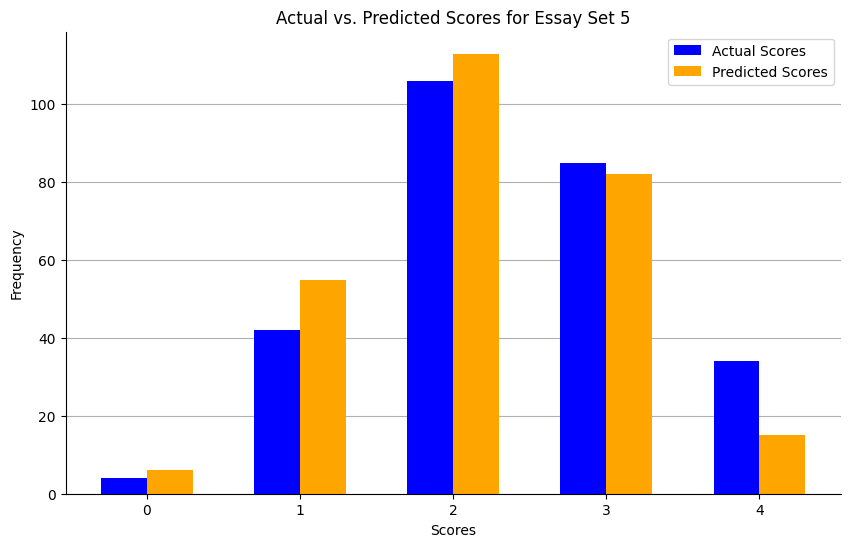

In [46]:
# Histogram for 5
actual_scores = final_scores_set5['domain1_score'].astype(int)
predicted_scores = final_scores_set5['predicted_domain1_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Making sure counts array lengths are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Predicted Scores for Essay Set 5')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()


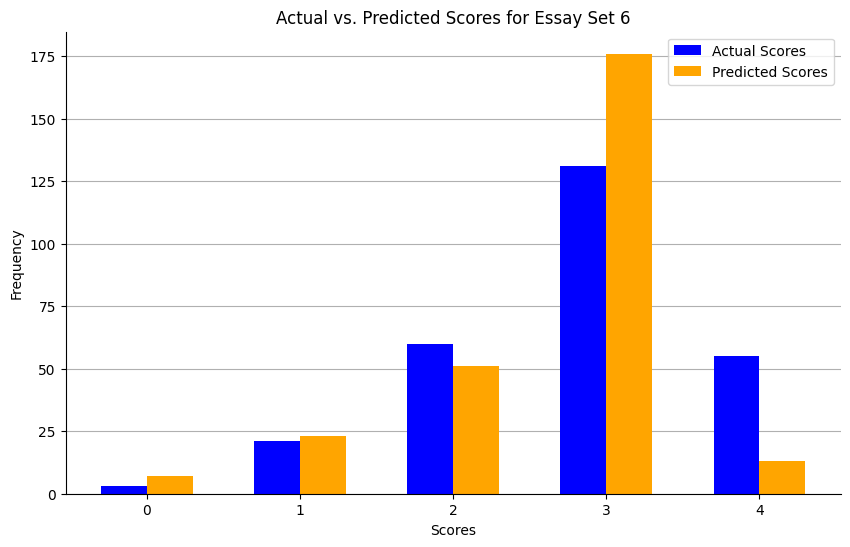

In [47]:
# Histogram for 6
actual_scores = final_scores_set6['domain1_score'].astype(int)
predicted_scores = final_scores_set6['predicted_domain1_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Making sure counts array lengths are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Predicted Scores for Essay Set 6')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()





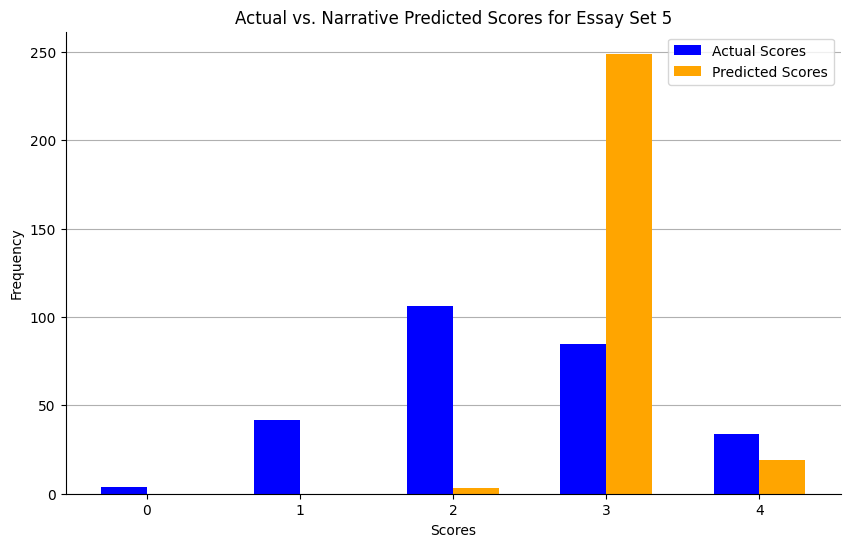

In [48]:
# narrative histogram for 5
actual_scores = final_scores_set5['domain1_score'].astype(int)
predicted_scores = final_scores_set5['narrative_predicted_domain1_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Making sure counts array lengths are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Narrative Predicted Scores for Essay Set 5')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()


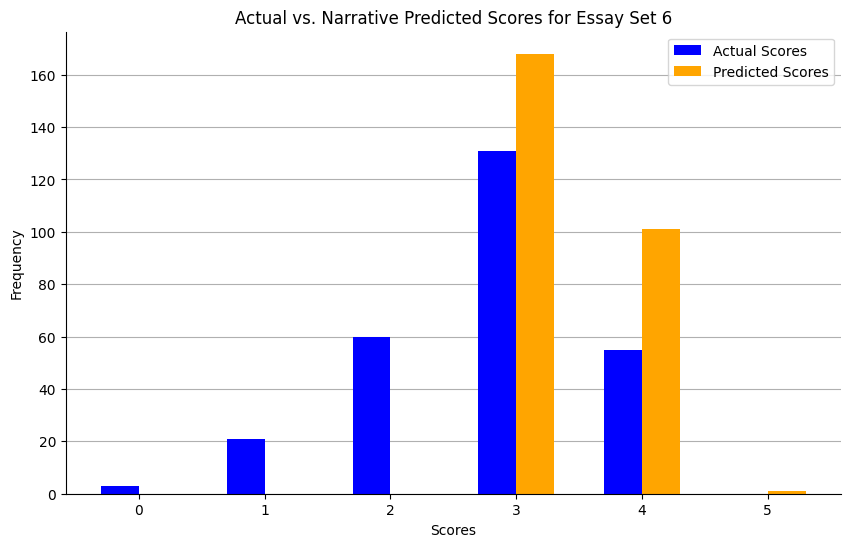

In [49]:
# narrative histogram for 5
actual_scores = final_scores_set6['domain1_score'].astype(int)
predicted_scores = final_scores_set6['narrative_predicted_domain1_score'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Making sure counts array lengths are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Narrative Predicted Scores for Essay Set 6')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()


In [90]:
# Essay Set 5
print_confusion_matrix(
    final_scores_set5['domain1_score'],
    final_scores_set5['predicted_domain1_score'],
    "Essay Set 5", "Source-Dependent Model"
)

print_confusion_matrix(
    final_scores_set5['domain1_score'],
    final_scores_set5['narrative_predicted_domain1_score'],
    "Essay Set 5", "Narrative Model"
)

# Essay Set 6
print_confusion_matrix(
    final_scores_set6['domain1_score'],
    final_scores_set6['predicted_domain1_score'],
    "Essay Set 6", "Source-Dependent Model"
)

print_confusion_matrix(
    final_scores_set6['domain1_score'],
    final_scores_set6['narrative_predicted_domain1_score'],
    "Essay Set 6", "Narrative Model"
)


Confusion Matrix for Source-Dependent Model in Essay Set 5:
[[ 2  2  0  0  0]
 [ 4 34  4  0  0]
 [ 0 19 82  5  0]
 [ 0  0 26 56  3]
 [ 0  0  1 21 12]]


Confusion Matrix for Narrative Model in Essay Set 5:
[[  0   0   0   4   0]
 [  0   0   3  39   0]
 [  0   0   0 106   0]
 [  0   0   0  80   5]
 [  0   0   0  20  14]]


Confusion Matrix for Source-Dependent Model in Essay Set 6:
[[  3   0   0   0   0]
 [  4  12   2   2   1]
 [  0  10  36  14   0]
 [  0   1  13 112   5]
 [  0   0   0  48   7]]


Confusion Matrix for Narrative Model in Essay Set 6:
[[ 0  0  0  3  0  0]
 [ 0  0  0 18  3  0]
 [ 0  0  0 52  8  0]
 [ 0  0  0 77 54  0]
 [ 0  0  0 18 36  1]
 [ 0  0  0  0  0  0]]




## Narrative essays

We move now to the narrative essays. Again, the process is identical in structure. In fact, it's even simpler; while previously test data was evaluated on their standard model (i.e. persuasive test data evaluated using the model trained on persuasive essays) as well as the narrative model, this test data is only evaluated using the model trained on narrative essays. It's quite curious how this model will perform given how poorly it performed for essays of other types.

Essay set 7 is considered first.

In [51]:
test_narrative_model_input = pd.read_csv('s3://698modeldata/test_narrative_model_input.csv')
final_narrative_predictions_df = pd.read_csv('s3://698modelpredictions/final_narrative_predictions_df.csv')

In [52]:
# Creating mapping df to associate essay ids with their essay set
essay_set_mapping = test_narrative_model_input[['essay_id', 'essay_set']].drop_duplicates()

# Merging to add essay set to the predictions dataframe
final_narrative_predictions_df = pd.merge(
    final_narrative_predictions_df,
    essay_set_mapping,
    on='essay_id',
    how='left'
)

# Filtering to only look at essay set 7
filtered_df = final_narrative_predictions_df[
    final_narrative_predictions_df['essay_set'] == 7
]

# Pivoting from long to wide so that each row represents one observation (essay)
pivot_df = filtered_df.pivot_table(
    index='essay_id',
    columns='feature',
    values='prediction',
    aggfunc='first'
).reset_index()




In [53]:
pivot_df.columns

Index(['essay_id', 'score_type_rater1_trait1', 'score_type_rater1_trait2',
       'score_type_rater1_trait3', 'score_type_rater1_trait4',
       'score_type_rater2_trait1', 'score_type_rater2_trait2',
       'score_type_rater2_trait3', 'score_type_rater2_trait4'],
      dtype='object', name='feature')

The scoring logic for essay 7 is that the resolved score is the sum of the two raters' scores which are the sums of the scores they give for the four traits.

In [54]:
def calculate_resolved_scores(df):
    df['predicted_rater1_resolved'] = df[['score_type_rater1_trait1', 'score_type_rater1_trait2', 'score_type_rater1_trait3', 'score_type_rater1_trait4']].sum(axis=1)
    df['predicted_rater2_resolved'] = df[['score_type_rater2_trait1', 'score_type_rater2_trait2', 'score_type_rater2_trait3', 'score_type_rater2_trait4']].sum(axis=1)
    df['predicted_final_resolved'] = df['predicted_rater1_resolved'] + df['predicted_rater2_resolved']
    return df

pivot_df = calculate_resolved_scores(pivot_df)


In [55]:
# Renaming for clarity
pivot_df.rename(columns={
    'score_type_rater1_trait1': 'predicted_rater1_trait1',
    'score_type_rater1_trait2': 'predicted_rater1_trait2',
    'score_type_rater1_trait3': 'predicted_rater1_trait3',
    'score_type_rater1_trait4': 'predicted_rater1_trait4',
    'score_type_rater2_trait1': 'predicted_rater2_trait1',
    'score_type_rater2_trait2': 'predicted_rater2_trait2',
    'score_type_rater2_trait3': 'predicted_rater2_trait3',
    'score_type_rater2_trait4': 'predicted_rater2_trait4'
}, inplace=True)


In [56]:
# filtering the actual score data to only consider essay set 7
set_data = test_narrative_model_input[test_narrative_model_input['essay_set'] == 7]

# Aggregating so that each essay is on one row
aggregated_scores_set7 = set_data.groupby('essay_id').agg({
    'essay_set': 'first',
    'rater1_trait1': 'max',
    'rater1_trait2': 'max',
    'rater1_trait3': 'max',
    'rater1_trait4': 'max',
    'rater2_trait1': 'max',
    'rater2_trait2': 'max',
    'rater2_trait3': 'max',
    'rater2_trait4': 'max',
    'rater1_domain1': 'max',
    'rater2_domain1': 'max',
    'domain1_score': 'max'
}).reset_index()

print(aggregated_scores_set7.head())


   essay_id  essay_set  rater1_trait1  rater1_trait2  rater1_trait3  \
0     17834          7            1.0            2.0            2.0   
1     17840          7            2.0            3.0            3.0   
2     17846          7            2.0            2.0            3.0   
3     17850          7            2.0            1.0            1.0   
4     17867          7            2.0            2.0            2.0   

   rater1_trait4  rater2_trait1  rater2_trait2  rater2_trait3  rater2_trait4  \
0            3.0            1.0            2.0            2.0            2.0   
1            3.0            3.0            3.0            3.0            3.0   
2            2.0            2.0            2.0            3.0            3.0   
3            1.0            2.0            2.0            1.0            2.0   
4            2.0            2.0            2.0            2.0            2.0   

   rater1_domain1  rater2_domain1  domain1_score  
0             8.0             7.0        

In [57]:
final_scores_set7 = pd.merge(aggregated_scores_set7, pivot_df, on='essay_id', how='left') # merging actual scores with predictions

In [58]:
final_scores_set7.columns

Index(['essay_id', 'essay_set', 'rater1_trait1', 'rater1_trait2',
       'rater1_trait3', 'rater1_trait4', 'rater2_trait1', 'rater2_trait2',
       'rater2_trait3', 'rater2_trait4', 'rater1_domain1', 'rater2_domain1',
       'domain1_score', 'predicted_rater1_trait1', 'predicted_rater1_trait2',
       'predicted_rater1_trait3', 'predicted_rater1_trait4',
       'predicted_rater2_trait1', 'predicted_rater2_trait2',
       'predicted_rater2_trait3', 'predicted_rater2_trait4',
       'predicted_rater1_resolved', 'predicted_rater2_resolved',
       'predicted_final_resolved'],
      dtype='object')

In [59]:
# Function to calculate QWK scores for set 7
def calculate_qwk_scores(pairs):
    results = {}
    for actual, predicted in pairs:
        score = cohen_kappa_score(
            final_scores_set7[actual],
            final_scores_set7[predicted],
            weights='quadratic'
        )
        results[f'QWK between {actual} and {predicted}'] = score
    return results # i.e. the dictionary with the results

# Traits and their predictions for raters 1 and 2
trait_pairs = [
    ('rater1_trait1', 'predicted_rater1_trait1'),
    ('rater1_trait2', 'predicted_rater1_trait2'),
    ('rater1_trait3', 'predicted_rater1_trait3'),
    ('rater1_trait4', 'predicted_rater1_trait4'),
    ('rater2_trait1', 'predicted_rater2_trait1'),
    ('rater2_trait2', 'predicted_rater2_trait2'),
    ('rater2_trait3', 'predicted_rater2_trait3'),
    ('rater2_trait4', 'predicted_rater2_trait4'),
    ('rater1_domain1', 'predicted_rater1_resolved'),
    ('rater2_domain1', 'predicted_rater2_resolved'),
    ('domain1_score', 'predicted_final_resolved')
]
results = calculate_qwk_scores(trait_pairs)

# Also want to compare the two raters
rater_comparison_pairs = [
    ('rater1_trait1', 'rater2_trait1'),
    ('rater1_trait2', 'rater2_trait2'),
    ('rater1_trait3', 'rater2_trait3'),
    ('rater1_trait4', 'rater2_trait4'),
    ('rater1_domain1', 'rater2_domain1')
]

rater_results = calculate_qwk_scores(rater_comparison_pairs)

# Combine two dictionaries, print
all_results = {**results, **rater_results}
for key, value in all_results.items():
    print(f"{key}: {value:.3f}")


QWK between rater1_trait1 and predicted_rater1_trait1: 0.688
QWK between rater1_trait2 and predicted_rater1_trait2: 0.578
QWK between rater1_trait3 and predicted_rater1_trait3: 0.554
QWK between rater1_trait4 and predicted_rater1_trait4: 0.636
QWK between rater2_trait1 and predicted_rater2_trait1: 0.723
QWK between rater2_trait2 and predicted_rater2_trait2: 0.625
QWK between rater2_trait3 and predicted_rater2_trait3: 0.689
QWK between rater2_trait4 and predicted_rater2_trait4: 0.590
QWK between rater1_domain1 and predicted_rater1_resolved: 0.757
QWK between rater2_domain1 and predicted_rater2_resolved: 0.776
QWK between domain1_score and predicted_final_resolved: 0.818
QWK between rater1_trait1 and rater2_trait1: 0.733
QWK between rater1_trait2 and rater2_trait2: 0.584
QWK between rater1_trait3 and rater2_trait3: 0.636
QWK between rater1_trait4 and rater2_trait4: 0.608
QWK between rater1_domain1 and rater2_domain1: 0.751


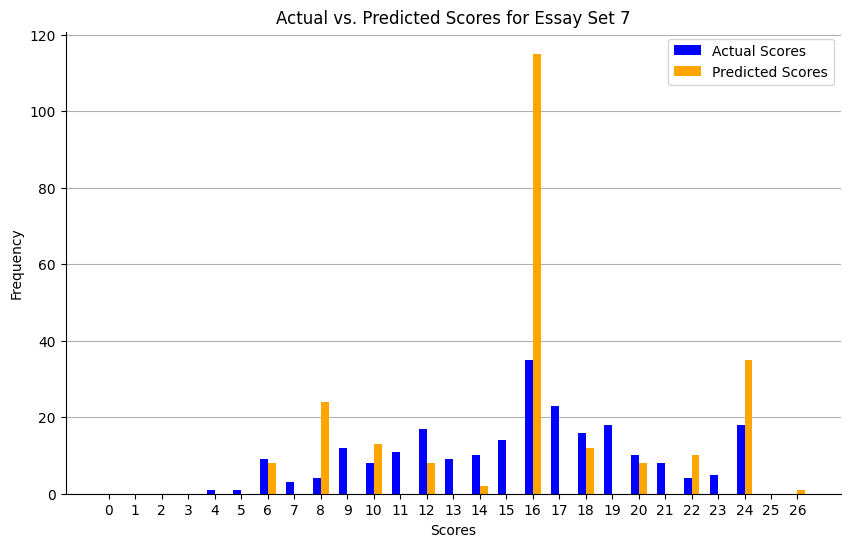

In [60]:
# Histogram for 7
actual_scores = final_scores_set7['domain1_score'].astype(int)
predicted_scores = final_scores_set7['predicted_final_resolved'].astype(int)

# Counts for each score
actual_counts = np.bincount(actual_scores)
predicted_counts = np.bincount(predicted_scores)

# Making sure counts array lengths are the same
max_length = max(len(actual_counts), len(predicted_counts))
actual_counts = np.pad(actual_counts, (0, max_length - len(actual_counts)), mode='constant')
predicted_counts = np.pad(predicted_counts, (0, max_length - len(predicted_counts)), mode='constant')

score_labels = np.arange(max_length)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Predicted Scores for Essay Set 7')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()





In [61]:
# Printing confusion matrix
print_confusion_matrix(
    final_scores_set7['domain1_score'],
    final_scores_set7['predicted_final_resolved'],
    "Essay Set 7", "Performance"
)

Confusion Matrix for Performance in Essay Set 7:
[[ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  1  0  1  0  0  0  4  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  2  0  1  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  3  0  0  0  1  0  4  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  4  0  1  0  0  0 11  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  1  0  6  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  1  0  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  2  0  0  0  0  0  9  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0 31  0  1  0  0  0  1  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 17  0  2  0  1  

In [76]:
final_scores_set7['domain1_score'].describe()

count    236.000000
mean      15.593220
std        4.763759
min        4.000000
25%       12.000000
50%       16.000000
75%       19.000000
max       24.000000
Name: domain1_score, dtype: float64

Moving on to the final essay set--set 8.

In [62]:
# filter to only include set 8
filtered_df = final_narrative_predictions_df[
    final_narrative_predictions_df['essay_set'] == 8
]

# Pivot from long to wide
pivot_df = filtered_df.pivot_table(
    index='essay_id',
    columns='feature',
    values='prediction',
    aggfunc='first'
).reset_index()





In [63]:
pivot_df.columns

Index(['essay_id', 'score_type_rater1_trait1', 'score_type_rater1_trait2',
       'score_type_rater1_trait5', 'score_type_rater1_trait6',
       'score_type_rater2_trait1', 'score_type_rater2_trait2',
       'score_type_rater2_trait5', 'score_type_rater2_trait6'],
      dtype='object', name='feature')

The scoring logic for this essay is a little more complex. The resolved score is again the sum of both raters' scores. Each rater's score is the sum of the scores they give for the four traits--however, the trait Conventions (this is trait6) is doubled. In other words, each rater's score is trait1 + trait2 + trait5 + 2(trait6)

In [64]:
def calculate_resolved_scores(df):
    trait_multipliers = {
        'trait1': 1,
        'trait2': 1,
        'trait5': 1,
        'trait6': 2  # trait6 needs to be added twice
    }

    # Calculate each rater's score
    for rater in ['rater1', 'rater2']:
        df[f'predicted_{rater}'] = sum(
            df[f'score_type_{rater}_{trait}'] * multiplier
            for trait, multiplier in trait_multipliers.items()
        )

    # Final resolved score calculated by summing both raters' scores
    df['predicted_final_resolved'] = df['predicted_rater1'] + df['predicted_rater2']

    return df

pivot_df = calculate_resolved_scores(pivot_df)
pivot_df.head()

feature,essay_id,score_type_rater1_trait1,score_type_rater1_trait2,score_type_rater1_trait5,score_type_rater1_trait6,score_type_rater2_trait1,score_type_rater2_trait2,score_type_rater2_trait5,score_type_rater2_trait6,predicted_rater1,predicted_rater2,predicted_final_resolved
0,20717,4,4,4,4,4,4,4,4,20,20,40
1,20721,3,3,3,3,3,3,3,3,15,15,30
2,20737,4,4,4,3,4,4,4,3,18,18,36
3,20745,3,3,3,3,3,3,3,3,15,15,30
4,20748,4,4,4,3,4,4,4,3,18,18,36


In [65]:
# Creating a new df for the actual scores--only for set 8
set_data = test_narrative_model_input[test_narrative_model_input['essay_set'] == 8]

# Aggregating -- one row per essay_id
aggregated_scores_set8 = set_data.groupby('essay_id').agg({
    'essay_set': 'first',
    'rater1_trait1': 'max',
    'rater1_trait2': 'max',
    'rater1_trait5': 'max',
    'rater1_trait6': 'max',
    'rater2_trait1': 'max',
    'rater2_trait2': 'max',
    'rater2_trait5': 'max',
    'rater2_trait6': 'max',
    'rater1_domain1': 'max',
    'rater2_domain1': 'max',
    'domain1_score': 'max'
}).reset_index()

print(aggregated_scores_set8.head())





   essay_id  essay_set  rater1_trait1  rater1_trait2  rater1_trait5  \
0     20717          8            5.0            4.0            4.0   
1     20721          8            3.0            2.0            2.0   
2     20737          8            4.0            4.0            4.0   
3     20745          8            3.0            4.0            3.0   
4     20748          8            4.0            4.0            3.0   

   rater1_trait6  rater2_trait1  rater2_trait2  rater2_trait5  rater2_trait6  \
0            4.0            6.0            5.0            5.0            5.0   
1            2.0            3.0            3.0            3.0            3.0   
2            4.0            4.0            4.0            4.0            4.0   
3            3.0            4.0            4.0            4.0            3.0   
4            4.0            4.0            4.0            3.0            3.0   

   rater1_domain1  rater2_domain1  domain1_score  
0            21.0            26.0        

In [66]:
# Renaming for clarity
pivot_df.rename(columns={
    'score_type_rater1_trait1': 'predicted_rater1_trait1',
    'score_type_rater1_trait2': 'predicted_rater1_trait2',
    'score_type_rater1_trait5': 'predicted_rater1_trait5',
    'score_type_rater1_trait6': 'predicted_rater1_trait6',
    'score_type_rater2_trait1': 'predicted_rater2_trait1',
    'score_type_rater2_trait2': 'predicted_rater2_trait2',
    'score_type_rater2_trait5': 'predicted_rater2_trait5',
    'score_type_rater2_trait6': 'predicted_rater2_trait6'
}, inplace=True)


In [67]:
# Merging the actual and predicted scores
final_scores_set8 = pd.merge(aggregated_scores_set8, pivot_df, on='essay_id', how='left')

The function to calculate QWK from earlier needs ever so slight modifications. It's pasted below and traits 3 and 4 are replaced with 5 and 6.

In [68]:
def calculate_qwk_scores8(pairs):
    results = {}
    for actual, predicted in pairs:
        score = cohen_kappa_score(
            final_scores_set8[actual],
            final_scores_set8[predicted],
            weights='quadratic'
        )
        results[f'QWK between {actual} and {predicted}'] = score
    return results

# Traits and their predictions for raters 1 and 2, ensuring the actual trait names are used
trait_pairs = [
    ('rater1_trait1', 'predicted_rater1_trait1'),
    ('rater1_trait2', 'predicted_rater1_trait2'),
    ('rater1_trait5', 'predicted_rater1_trait5'),
    ('rater1_trait6', 'predicted_rater1_trait6'),
    ('rater2_trait1', 'predicted_rater2_trait1'),
    ('rater2_trait2', 'predicted_rater2_trait2'),
    ('rater2_trait5', 'predicted_rater2_trait5'),
    ('rater2_trait6', 'predicted_rater2_trait6'),
    ('rater1_domain1', 'predicted_rater1'),
    ('rater2_domain1', 'predicted_rater2'),
    ('domain1_score', 'predicted_final_resolved')
]
results = calculate_qwk_scores8(trait_pairs)

# Also want to compare the two raters
rater_comparison_pairs = [
    ('rater1_trait1', 'rater2_trait1'),
    ('rater1_trait2', 'rater2_trait2'),
    ('rater1_trait5', 'rater2_trait5'),
    ('rater1_trait6', 'rater2_trait6'),
    ('rater1_domain1', 'rater2_domain1')
]

rater_results = calculate_qwk_scores8(rater_comparison_pairs)

# Combine two dictionaries, print
all_results = {**results, **rater_results}
for key, value in all_results.items():
    print(f"{key}: {value:.3f}")


QWK between rater1_trait1 and predicted_rater1_trait1: 0.492
QWK between rater1_trait2 and predicted_rater1_trait2: 0.532
QWK between rater1_trait5 and predicted_rater1_trait5: 0.591
QWK between rater1_trait6 and predicted_rater1_trait6: 0.548
QWK between rater2_trait1 and predicted_rater2_trait1: 0.363
QWK between rater2_trait2 and predicted_rater2_trait2: 0.470
QWK between rater2_trait5 and predicted_rater2_trait5: 0.328
QWK between rater2_trait6 and predicted_rater2_trait6: 0.355
QWK between rater1_domain1 and predicted_rater1: 0.701
QWK between rater2_domain1 and predicted_rater2: 0.487
QWK between domain1_score and predicted_final_resolved: 0.664
QWK between rater1_trait1 and rater2_trait1: 0.515
QWK between rater1_trait2 and rater2_trait2: 0.543
QWK between rater1_trait5 and rater2_trait5: 0.509
QWK between rater1_trait6 and rater2_trait6: 0.483
QWK between rater1_domain1 and rater2_domain1: 0.624


A histogram for 8 will now be plotted. Because the range of possible scores is large, let's see what range we actually need to plot.

In [69]:
print(final_scores_set8['domain1_score'].min())
print(final_scores_set8['domain1_score'].max())
print(final_scores_set8['predicted_final_resolved'].min())
print(final_scores_set8['predicted_final_resolved'].max())

20.0
47.0
30
46


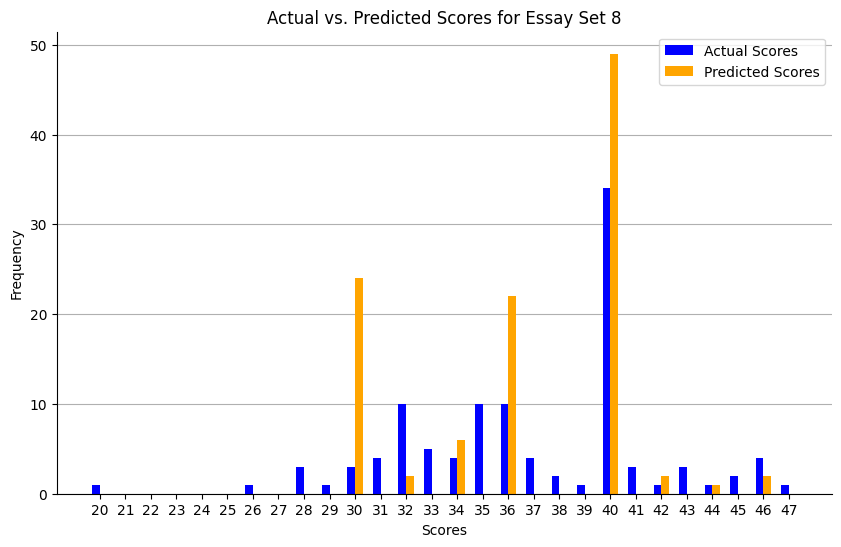

In [70]:
# Histogram for 8 - plotting from 20 to 47
actual_scores = final_scores_set8['domain1_score'].astype(int)
predicted_scores = final_scores_set8['predicted_final_resolved'].astype(int)

# Being explicit to include 20 through 47
actual_counts = np.bincount(actual_scores, minlength=48)[20:48]
predicted_counts = np.bincount(predicted_scores, minlength=48)[20:48]

score_labels = np.arange(20, 48)

# Plot histogram
plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.bar(score_labels - 0.15, actual_counts, width=0.3, label='Actual Scores', color='blue', align='center')
plt.bar(score_labels + 0.15, predicted_counts, width=0.3, label='Predicted Scores', color='orange', align='center')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Actual vs. Predicted Scores for Essay Set 8')
plt.xticks(score_labels)
plt.legend()
plt.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True) # So that the lines don't cut through the bars
plt.show()





In [71]:
# Printing confusion matrix
print_confusion_matrix(
    final_scores_set8['domain1_score'],
    final_scores_set8['predicted_final_resolved'],
    "Essay Set 8", "Performance"
)

Confusion Matrix for Performance in Essay Set 8:
[[ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  2  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  1  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  1  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  5  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  4  0  0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  2  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  

Scoring is now complete and will be analyzed in the written piece.